# LR Finder for Tiny ImageNet

In [0]:
!pip install imgaug

In [0]:
!pip install --upgrade scikit-image

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!cp '/content/gdrive/My Drive/App/Tiny/MyUtils.zip' /content
!unzip -q /content/MyUtils.zip

!cp '/content/gdrive/My Drive/App/Tiny/Mod/tiny-imagenet-200.zip' /content
!unzip -q /content/tiny-imagenet-200.zip

In [0]:
import keras
import os
import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv1D
from keras.layers import Dense
from keras.applications import ResNet50

from keras.utils import plot_model

from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam

In [0]:
## configurations ##
ROOT_DIR='/content'
IMAGE_ROOT_DIR=os.path.join(ROOT_DIR, 'tiny-imagenet-200')

''' 
# utilities.
UTILS_ROOT_DIR='/content'
MY_UTILS_DIR= os.path.join(UTILS_ROOT_DIR,'MyUtils')
SUPPORT_FILES_DIR=os.path.join(MY_UTILS_DIR, 'SupportFiles')
'''

train_data_dir = os.path.join(IMAGE_ROOT_DIR,'train')
validation_data_dir = os.path.join(IMAGE_ROOT_DIR, 'val')
num_train_samples = 100000
num_validation_samples = 10000

## colab crashes, so need to multiple runs - may be 25 epochs three times.
epochs = 5
batch_size = 256

img_height = 64
img_width  = 64
num_channel = 3
num_classes = 200

In [0]:
img_shape = (64,64,3)
num_classes = 200
input = Input(shape=img_shape)

In [5]:
# use pretrained resnet weights - gives features of size 2048
base_model = ResNet50(include_top=False, weights='imagenet',pooling='avg', input_tensor=input)


Instructions for updating:
Colocations handled automatically by placer.


In [8]:
head_model = Dense(num_classes)(base_model.output)

model = Model(input=base_model.input, output=head_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
train_datagen = ImageDataGenerator()

## train generator
train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='categorical')

label_dict = train_generator.class_indices

print(label_dict.keys())
print(label_dict.values())

## validation generator
 
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 100000 images belonging to 200 classes.
dict_keys(['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815

In [0]:
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

## LR Finder

In [0]:
import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [0]:
lr_finder = LRFinder(min_lr=1e-6, max_lr=0.1, steps_per_epoch=97, epochs=5)

In [0]:
lr_callback_list = [lr_finder]

## Training

In [23]:
batch_size = 1024

H = model.fit_generator(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size,
    callbacks = lr_callback_list,
    #initial_epoch=50
)

Epoch 1/5
97/97 [==============================] - 72s 745ms/step - loss: 8.2085 - acc: 0.0048 - val_loss: 8.1357 - val_acc: 0.0039
Epoch 2/5
97/97 [==============================] - 71s 731ms/step - loss: 8.1538 - acc: 0.0048 - val_loss: 8.1709 - val_acc: 0.0068
Epoch 3/5
97/97 [==============================] - 71s 732ms/step - loss: 8.1015 - acc: 0.0052 - val_loss: 8.3268 - val_acc: 0.0039
Epoch 4/5
97/97 [==============================] - 71s 736ms/step - loss: 8.0816 - acc: 0.0048 - val_loss: 8.2613 - val_acc: 0.0030
Epoch 5/5
97/97 [==============================] - 72s 740ms/step - loss: 8.5123 - acc: 0.0053 - val_loss: 9.2786 - val_acc: 0.0026


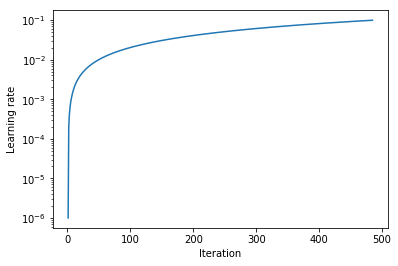

In [24]:
lr_finder.plot_lr()

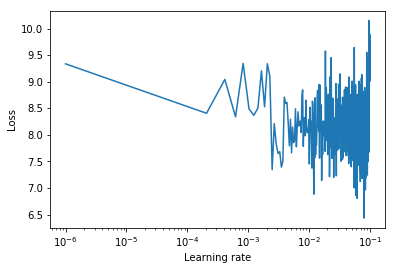

In [25]:
lr_finder.plot_loss()